Average Conductance = 0.2588


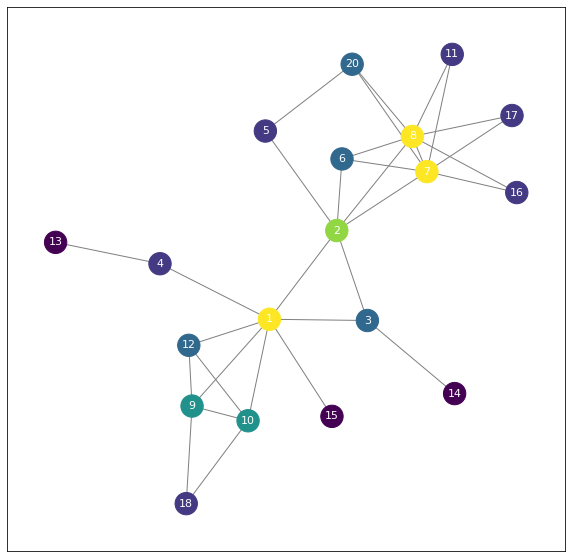

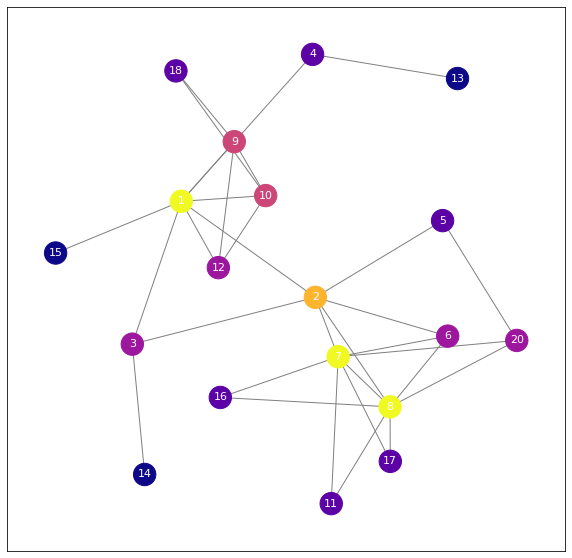

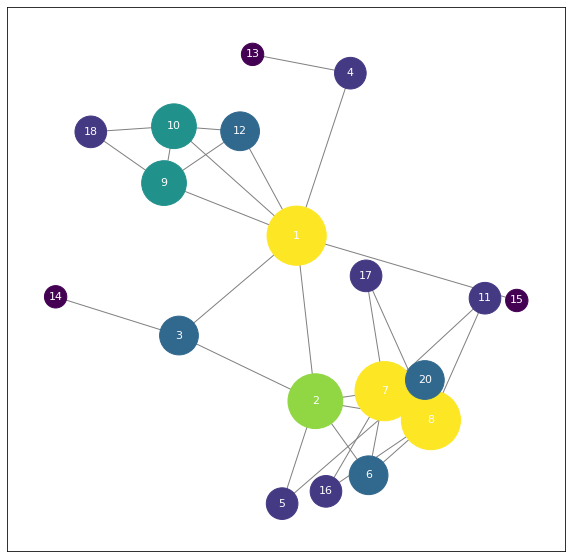

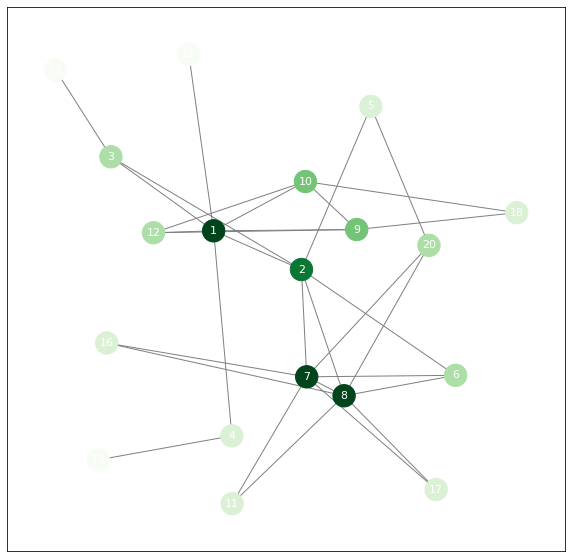

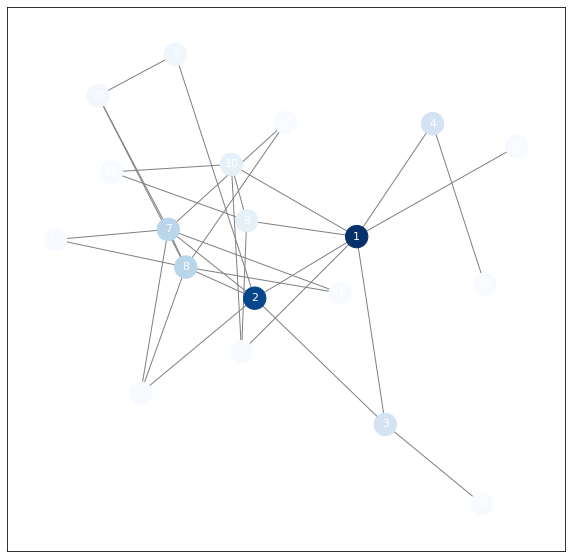

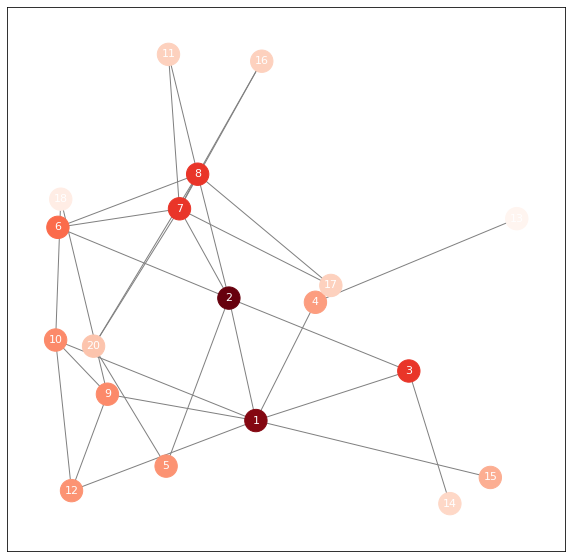

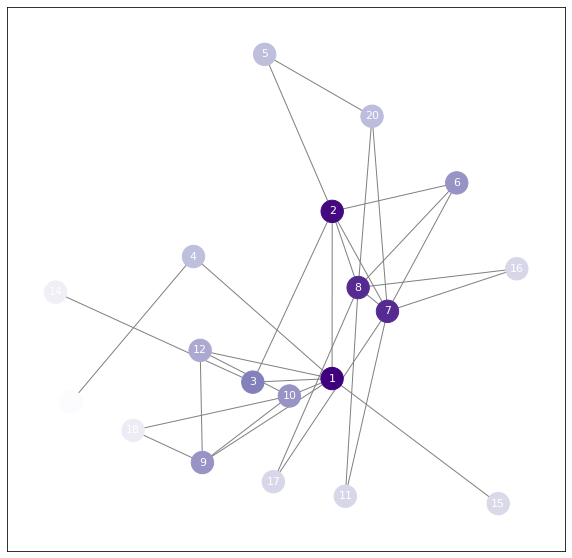

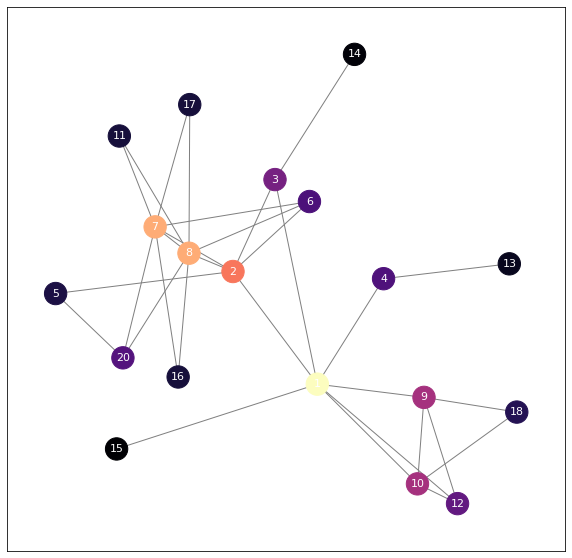

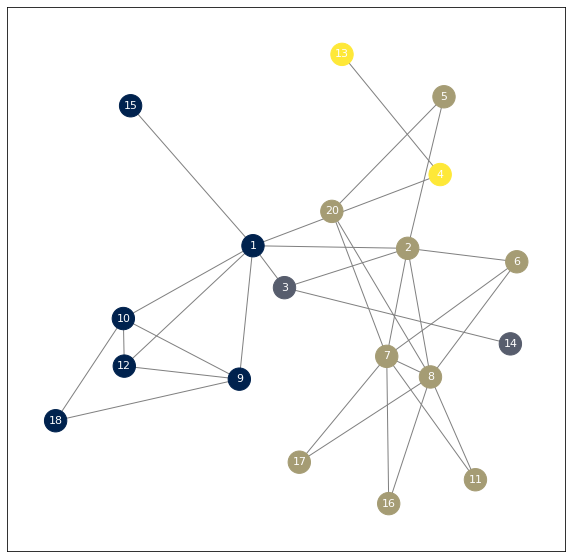

In [4]:
# Variables
flag_opened_dn = True
flag_opened_ane = True
flag_opened_cm = True
flag_opened_la = True
flag_opened_cde = True
flag_opened_cda = True

right_arrow_symbol = "🡆"
down_arrow_symbol = "🡇"

G = None
p = None
G1 = None

# Imports
import csv, os
WKDIR = os.getcwd()

import community
import numpy as np
import pandas as pd
import networkx as nx

import PySimpleGUI as sg
sg.theme('SystemDefaultForReal') 

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, text
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from sklearn.metrics.cluster import normalized_mutual_info_score

# Functions
def create_graph():
    
    nodes = values['-FILE_PATH_NODES-']
    nodes_data = pd.read_csv(nodes, header=0)
    nodes_attributes_names = nodes_data.columns[1:]
    
    edges = values['-FILE_PATH_EDGES-']
    edges_data = pd.read_csv(edges, header=0)
    edges_attributes_names = edges_data.columns[2:]
    
    bool_directed = values['-DIRECTED-']
    bool_weighted = values['-WEIGHTED-']
   
    if bool_directed:
        if bool_weighted:
            H = nx.DiGraph()
        else:
            H = nx.DiGraph()
    else:
        if bool_weighted:
            H = nx.Graph()
        else:
            H = nx.Graph()

    for r in nodes_data.itertuples(index = False):
        nodes_id = r[0]
        nodes_attributes = r[1:]
        H.add_node(nodes_id, **dict(zip(nodes_attributes_names, nodes_attributes)))

    for r in edges_data.itertuples(index = False):
        s, t, edges_attributes = r[0], r[1], r[2:]
        H.add_edge(s, t, **dict(zip(edges_attributes_names, edges_attributes)))
    
    return H

def draw_figure(canvas, figure):
    fca = FigureCanvasTkAgg(figure, canvas)
    fca.draw()
    fca.get_tk_widget().place(relx = 0.5, rely = 0.5, anchor = 'center')
    return fca

def draw_graph(s):
    
    fig = plt.figure(figsize = (10, 10))
    fig.clear()
    pos = nx.fruchterman_reingold_layout(G, k = 1.0)
    node_size = 500
    nodes_with_labels = True
    font_size = 11
    cmap = 'rainbow_r'
    edge_color = "grey"
    font_color = "white"
    
    if s == "main_graph": 
        
        nodes_size = [G.degree(n) * 2000 for n in G]
        nodes_color = nodes_size
        cmap = 'viridis'
        if not bool_directed:
            pos = nx.kamada_kawai_layout(G)
    
    elif s == "node_degree_graph": 

        degrees = dict(G.degree())
        nodes_size = [degrees[n] * 1000 for n in G.nodes()]
        nodes_color = nodes_size
        cmap = 'plasma'
    
    elif s == "edge_weight_graph": 
       
        nodes_size = [G1.degree(n) * 500 for n in G1]
        nodes_color = nodes_size
        cmap = 'inferno'
        edge_weights = nx.get_edge_attributes(G1, 'weight')
        edge_widths = [e for e in edge_weights.values()]
        nx.draw_networkx_nodes(G1, pos, node_size = nodes_size, node_color = nodes_color)
        nx.draw_networkx_edges(G1, pos, width = edge_widths, edge_color = edge_color)
        nx.draw_networkx_labels(G1, pos, font_size = font_size, font_color = font_color)
        
    elif s == "closeness_centrality_graph":
        
        closeness_centrality= get_closeness_centrality(G)
        nodes_size = [c_c * 10000 for c_c in closeness_centrality.values()]
        nodes_color = nodes_size
        cmap = "Reds"
   
    elif s == "betweenness_centrality_graph": 

        betweenness_centrality = nx.betweenness_centrality(G)
        nodes_size = [b_c * 10000 for b_c in nx.betweenness_centrality(G).values()]
        nodes_color = nodes_size
        cmap = 'Blues'
        
    elif s == "harmonic_centrality_graph": 

        h_c = get_harmonic_centrality(G)
        nodes_size = [v * 1000 for v in h_c.values()]
        nodes_color = nodes_size
        cmap = 'Purples'

    elif s == "degree_centrality_graph": 

        d_c = get_degree_centrality(G)
        nodes_size = [v * 10000 for v in d_c.values()]
        nodes_color = nodes_size
        cmap = 'Greens'
   
    elif s == "page_rank_graph": 

        pagerank_scores = nx.pagerank(G, alpha=0.85,max_iter=100)
        nodes_size = [p_r * 10000 for p_r in pagerank_scores.values()]
        nodes_color = nodes_size
        cmap = 'magma'
    
    elif s == "louvain_graph": 
        
        p = community.best_partition(G)
        nodes_color = list(p.values())
        cmap = 'cividis'

    if s != "edge_weight_graph":
        
        nx.draw_networkx(G, pos, node_size = node_size, with_labels = nodes_with_labels, node_color = nodes_color, cmap = cmap, edge_color = edge_color, font_size = font_size, font_color = font_color)
    
    return plt.gcf()

def get_conductance_for_directed_graph(H, comms):
    
    inner_edges = 0
    outer_edges = 0
    minimum_deg_sum = float("inf")
    for comm in set(comms.values()):
        deg_sum = sum(H.degree(n) for n in comms if comms[n] == comm)
        minimum_deg_sum = min(minimum_deg_sum, deg_sum)
    for n in H.nodes():
        for neighbor in H.neighbors(n):
            if comms[n] == comms[neighbor]:
                inner_edges += 1
            else:
                outer_edges += 1
    c = outer_edges / minimum_deg_sum
    return c

def get_closeness_centrality(G):
    if G.is_directed():
        c_c = nx.closeness_centrality(G, wf_improved = True)
    else:
        c_c = nx.closeness_centrality(G)
    return c_c

def get_harmonic_centrality(G):
    
    if (bool_directed and bool_weighted) or (not bool_directed and bool_weighted):
        h_c = nx.harmonic_centrality(G, distance = 'weight')
    if (not bool_directed and not bool_weighted) or (bool_directed and not bool_weighted):
        h_c = nx.harmonic_centrality(G)
    return h_c

def get_degree_centrality(G):
    if G.is_directed():
        d_c = nx.out_degree_centrality(G)
    else:
        d_c = nx.degree_centrality(G)
    return d_c

def collapse(layout, key):
    return sg.pin(sg.Column(layout, key = key))

def adjust_weights():
    if bool_directed:
        M = nx.DiGraph()
    else:
        M = nx.Graph()
    for i, j, data in G.edges(data = True):
        w_ = 1.0 if 'weight' not in data else data['weight']
        if M.has_edge(i,j):
            M[i][j]['weight'] += w_
        else:
            M.add_edge(i, j, weight = w_)    
    return M

def create_table(headers, data, title):
    
    table_layout = [
        [sg.Table(values = data, headings = headers, max_col_width = 40, expand_x = True, expand_y = True, auto_size_columns = True, justification = 'right', alternating_row_color = 'lightGrey', num_rows = 10, display_row_numbers = True, key = '-TABLE-', row_height = 35, tooltip = title)],       
    ]
    
    table_window = sg.Window(title, table_layout, modal = True, element_justification = 'center', resizable = True)
    
    while True:
        event, values = table_window.read()
        if event == sg.WIN_CLOSED:
            break
            
    table_window.close()
    
def second_window(bool_directed, choice):
    
    if choice == "node_degree":
    
        if not bool_directed:
            Node_Degrees = dict(G.degree())
            table_data = [[n, Node_Degrees[n]] for n in Node_Degrees]
            table_data.sort(key = lambda x: x[1], reverse = True)
            data = pd.DataFrame(table_data, columns = ['Node ID', 'Node Degree'])
        else:
            Node_In_Degrees = dict(G.in_degree())
            Node_Out_Degrees = dict(G.out_degree())
            table_data = []
            for n in G.nodes():
                 table_data.append([n, Node_In_Degrees.get(n, 0), Node_Out_Degrees.get(n, 0)])
            data = pd.DataFrame(table_data, columns = ['Node ID', 'In-Degree', 'Out-Degree'])
        title = "Adjusting Node Degree"
        s = "node_degree_graph"
        table_text = "Sorted Table of Nodes Based on Node Degree"
        canvas_text = "Differentiating Between Nodes Based on Node Degree"

    elif choice == "edge_weight":
        
        edges_weights = nx.get_edge_attributes(G1, 'weight')
        table_data = [[w, edges_weights[w]] for w in edges_weights]
        table_data.sort(key = lambda x: x[1], reverse = True)
        data = pd.DataFrame(table_data, columns = ['Edge', 'Edge Weight'])
        title = 'Adjusting Edge Weight'
        s = "edge_weight_graph"
        table_text = "Sorted Table of Edges Based on Edge Weight"
        canvas_text = "Differentiating between edges based on edge weight"
        
    elif choice == "closeness_centrality":
        
        c_c = get_closeness_centrality(G)
        table_data = [[n, c_c[n]] for n in c_c]
        table_data.sort(key = lambda x: x[1], reverse = True)
        data =  pd.DataFrame(table_data, columns = ['Node ID', 'Closeness Centrality'])
        title = "Closeness Centrality Measure"
        s = "closeness_centrality_graph"
        table_text = "Sorted Table of Nodes Based on Closeness Centrality"
        canvas_text = "Differentiating between nodes based on closeness centrality"
    
    elif choice == "betweenness_centrality":
        
        b_c = nx.betweenness_centrality(G)
        table_data = [[n, b_c[n]] for n in b_c]
        table_data.sort(key = lambda x: x[1], reverse=True)
        data = pd.DataFrame(table_data, columns = ['Node ID', 'Betweenness Centrality'])
        title = "Betweenness Centrality Measure"
        s = "betweenness_centrality_graph"
        table_text = "Sorted Table of Nodes Based on Betweenness Centrality"
        canvas_text = "Differentiating between nodes based on betweenness centrality"

    
    elif choice == "harmonic_centrality":
        
        h_c = get_harmonic_centrality(G)
        table_data = [[n, h_c[n]] for n in h_c]
        table_data.sort(key = lambda x: x[1], reverse = True)
        data = pd.DataFrame(table_data, columns = ['Node ID', 'Harmonic Centrality'])
        title = "Harmonic Centrality Measure"
        s = "harmonic_centrality_graph"
        table_text = "Sorted Table of Nodes Based on Harmonic Centrality"
        canvas_text = "Differentiating between nodes based on harmonic centrality"

    
    elif choice == "degree_centrality":
        
        d_c = get_degree_centrality(G)
        table_data = [[n, d_c[n]] for n in d_c]
        table_data.sort(key = lambda x: x[1], reverse = True)
        data = pd.DataFrame(table_data, columns = ['Node ID', 'Degree Centrality'])
        title = "Degree Centrality Measure"
        s = "degree_centrality_graph"
        table_text = "Sorted Table of Nodes Based on Degree Centrality"
        canvas_text = "Differentiating between nodes based on degree centrality"

    
    elif choice == "page_rank":
        
        pagerank_scores = nx.pagerank(G, alpha=0.85, max_iter = 100)
        table_data = [[n, pagerank_scores[n]] for n in pagerank_scores]
        table_data.sort(key = lambda x: x[1], reverse = True)
        data = pd.DataFrame(table_data, columns = ['Node ID', 'Pagerank Scores'])
        title = "Pagerank"
        s = "page_rank_graph"
        table_text = "Sorted Table of Nodes Based on Page Rank Scores"
        canvas_text = "Differentiating between nodes based on page rank scores"
        
    canvas_column = [
        [sg.Text(canvas_text, font = ('Helvetica', 15))],
        [sg.Canvas(size = (800, 800), key = "-SW_CANVAS-")]
    ]
    
    table_column = [
        [sg.Text(table_text, font = ('Helvetica', 15))],
        [sg.Table(values = data.values.tolist(), headings = data.columns.tolist(), key = "-SW_TABLE-", max_col_width = 25, auto_size_columns = True, justification = 'center')]
    ]
    
    layout = [ 
        [sg.Col(canvas_column, element_justification = 'center'), sg.VerticalSeparator(), sg.Col(table_column, element_justification = 'center')]
    ]

    second_window = sg.Window(title, layout, resizable = True, finalize = True)
    
    draw_figure(second_window["-SW_CANVAS-"].TKCanvas, draw_graph(s))

    while True:
        event,values = second_window.read()
        if event == sg.WIN_CLOSED:
            break

    second_window.close()
    
# Sections
section_cda = [
    [sg.Text('Louvain Algorithm', font = ('Helvetica', 13), size = (22, 0)), sg.Button('Run', key = '-LOV-', button_color = 'White')],
]

section_cde = [
    [sg.Text('Conductance',font = ('Helvetica', 13), size = (22, 0)), sg.Button('Run', key = "-COND-",button_color = 'White')],
    [sg.Text('Modularity', font = ('Helvetica', 13), size = (22, 0)), sg.Button('Run',key = "-MOD-", button_color = 'White')],
    [sg.Text('NMI', font = ('Helvetica', 13), size = (22, 0)), sg.Button('Run',key = "-NMI-", button_color = 'White')]
]

section_link_analysis_techniques = [
    [sg.Text('Page Rank', font = ('Helvetica', 13), size = (22, 0)), sg.Button('Run', key="-PR-" ,button_color = 'White')],
]

section_ane = [
    [sg.Text('Node Degree', font = ('Helvetica', 13), size = (22, 0)), sg.Button('Run', key = "-ND-", button_color = 'White')],
    [sg.Text('Edge Weight', font = ('Helvetica', 13), size = (22, 0)), sg.Button('Run', key = "-EW-", button_color = 'White')],
]

section_cm = [
    [sg.Text('Degree Centrality', font = ('Helvetica', 13), size = (22, 0)), sg.Button('Run', key = "-DC-", button_color = 'White')],
    [sg.Text('Betweenness Centrality', font = ('Helvetica', 13), size = (22, 0)), sg.Button('Run', key = "-BC-", button_color = 'White')],
    [sg.Text('Closeness Centrality', font = ('Helvetica', 13), size = (22, 0)), sg.Button('Run', key = "-CC-", button_color = 'White')],
    [sg.Text('Harmonic Centrality', font = ('Helvetica', 13), size = (22, 0)), sg.Button('Run', key = "-HC-", button_color = 'White')],
]

section_dn = [
    [sg.Text('Create Network', font = ('Helvetica', 13), size = (22, 0)), sg.Button('Run', key = '-CREATE_GRAPH-', font = ('Helvetica', 13))], 
    [sg.Text('Show Nodes Table', font = ('Helvetica', 13), size = (22, 0)), sg.Button('Run', key = '-NODES_TABLE-', font = ('Helvetica', 13))], 
    [sg.Text('Show Edges Table', font = ('Helvetica', 13), size = (22, 0)), sg.Button('Run', key = '-EDGES_TABLE-', font = ('Helvetica', 13))],

]

# Columns
canvas_column = [
        [sg.Text('Import Nodes:', font = ('Helvetica', 13)), sg.InputText(key='-FILE_PATH_NODES-', font = ('Helvetica', 13)), sg.FileBrowse(initial_folder = WKDIR, font = ('Helvetica', 13), file_types=(("CSV Files", "*.csv"),)), sg.Checkbox('Directed', key='-DIRECTED-', font = ('Helvetica', 13))], 
        [sg.Text('Import Edges:', font = ('Helvetica', 13)), sg.InputText(key='-FILE_PATH_EDGES-', font = ('Helvetica', 13)), sg.FileBrowse(initial_folder = WKDIR, font = ('Helvetica', 13), file_types=(("CSV Files", "*.csv"),)), sg.Checkbox('Weighted', key='-WEIGHTED-', font = ('Helvetica', 13))],
        [sg.Canvas(size = (600, 600), key = "-CANVAS-")],
        [sg.Text(key = '-CANVAS_TEXT-', font = ('Helvetica', 15), visible = False)]
]

sections_column = [
    [sg.Text(down_arrow_symbol, font = ('Helvetica', 14), enable_events = True, key = '-OPEN_SEC_DN-'), sg.Text("Data & Networks", font = ('Helvetica', 13))],
    [collapse(section_dn, '-SEC_DN-')],
    [sg.Text(down_arrow_symbol, font = ('Helvetica', 14), enable_events = True, key = '-OPEN_SEC_ANE-'), sg.Text("Adjust Nodes & Edges", font = ('Helvetica', 13))],
    [collapse(section_ane, '-SEC_ANE-')],
    [sg.Text(down_arrow_symbol, font = ('Helvetica', 14), enable_events = True, key = '-OPEN_SEC_CM-'), sg.Text("Centrality Measures", font = ('Helvetica', 13))],
    [collapse(section_cm, '-SEC_CM-')],
    [sg.Text(down_arrow_symbol, font = ('Helvetica', 14), enable_events = True, key = '-OPEN_SEC_LA-'), sg.Text("Link Analysis Techniques", font = ('Helvetica', 13))],
    [collapse(section_link_analysis_techniques, '-SEC_LA-')],
    [sg.Text(down_arrow_symbol, font = ('Helvetica', 14), enable_events = True, key = '-OPEN_SEC_CDE-'), sg.Text("Community Detection Evaluations", font = ('Helvetica', 13))],
    [collapse(section_cde, '-SEC_CDE-')],
    [sg.Text(down_arrow_symbol, font = ('Helvetica', 14), enable_events = True, key = '-OPEN_SEC_CDA-'), sg.Text("Community Detection Algorithms", font = ('Helvetica', 13))],
    [collapse(section_cda, '-SEC_CDA-')],
]

# Layouts
main_layout = [
   [sg.Col(canvas_column, element_justification = 'center'), sg.VerticalSeparator(), sg.Col(sections_column, element_justification = 'left')],
]

window = sg.Window('MSNAT (Mini Social Networks Analysis Tool)', main_layout, element_justification = 'center', resizable = True, finalize = True)

while True:
    
    event,values = window.read()
    
    if event == sg.WIN_CLOSED:
        break
    
    if values is not None:
        bool_directed = values['-DIRECTED-']
        bool_weighted = values['-WEIGHTED-']
        nodes = values['-FILE_PATH_NODES-']
        edges = values['-FILE_PATH_EDGES-']
       
    if event == '-OPEN_SEC_DN-':
        flag_opened_dn = not flag_opened_dn
        window['-OPEN_SEC_DN-'].update(down_arrow_symbol if flag_opened_dn else right_arrow_symbol)
        window['-SEC_DN-'].update(visible = flag_opened_dn)
        
    if event == '-OPEN_SEC_ANE-':
        flag_opened_ane = not flag_opened_ane
        window['-OPEN_SEC_ANE-'].update(down_arrow_symbol if flag_opened_ane else right_arrow_symbol)
        window['-SEC_ANE-'].update(visible = flag_opened_ane)
    
    if event == '-OPEN_SEC_CM-':
        flag_opened_cm = not flag_opened_cm
        window['-OPEN_SEC_CM-'].update(down_arrow_symbol if flag_opened_cm else right_arrow_symbol)
        window['-SEC_CM-'].update(visible = flag_opened_cm)
        
    if event == '-OPEN_SEC_CDE-':
        flag_opened_cde = not flag_opened_cde
        window['-OPEN_SEC_CDE-'].update(down_arrow_symbol if flag_opened_cde else right_arrow_symbol)
        window['-SEC_CDE-'].update(visible = flag_opened_cde)
        
    if event == '-OPEN_SEC_LA-':
        flag_opened_la = not flag_opened_la
        window['-OPEN_SEC_LA-'].update(down_arrow_symbol if flag_opened_la else right_arrow_symbol)
        window['-SEC_LA-'].update(visible = flag_opened_la)
        
    if event == '-OPEN_SEC_CDA-':
        flag_opened_cda = not flag_opened_cda
        window['-OPEN_SEC_CDA-'].update(down_arrow_symbol if flag_opened_cde else right_arrow_symbol)
        window['-SEC_CDA-'].update(visible = flag_opened_cda)
   
    if event == '-CREATE_GRAPH-' and nodes != "" and edges != "":
        G = create_graph()
        info = " Graph Successfully Created ❕" + "\n" + "▪ Inforamtion about the graph" + "\n" + "✦ Number of nodes: " + str(G.number_of_nodes()) + "\n" + "✦ Number of edges: " + str(G.number_of_edges()) + "\n" + "✦ Directed: " + str(bool_directed) + "\n" + "✦ Weighted: " + str(bool_weighted)
        sg.popup_no_buttons(info, title = "Message", font = ('Helvetica', 13), keep_on_top = True)
        draw_figure(window["-CANVAS-"].TKCanvas, draw_graph("main_graph"))
        window['-CANVAS_TEXT-'].update(value = "Network's Graph", visible = True)
    
    if event == '-CREATE_GRAPH-' and nodes == "" and edges == "":
        sg.popup_no_buttons("Please select the paths for nodes and edges first ❕", title = "Alert", font = ('Helvetica', 13))

    if event == "-NODES_TABLE-" and nodes != "":
        nodes_file = pd.read_csv(nodes)
        nodes_data = nodes_file.to_numpy()
        nodes_headers = nodes_file.columns.to_numpy()
        create_table(nodes_headers.tolist(), nodes_data.tolist(), "Nodes Table")

    if event == "-EDGES_TABLE-" and edges != "":
        edges_file = pd.read_csv(edges)
        edges_data = edges_file.to_numpy()
        edges_headers = edges_file.columns.to_numpy()
        create_table(edges_headers.tolist(), edges_data.tolist(), "Edges Table")
        
    if event == '-ND-' and G != None:
        second_window(bool_directed, "node_degree")
        
    if event == '-EW-' and G != None:   
        G1 = adjust_weights()
        second_window(bool_directed, "edge_weight")
        
    if event == '-CC-' and G != None:
        second_window(bool_directed, "closeness_centrality")
    
    if event == "-BC-" and G != None:
        second_window(bool_directed, "betweenness_centrality")
        
    if event == '-HC-' and G != None:
        second_window(bool_directed, "harmonic_centrality")
   
    if event == '-DC-' and G != None:
         second_window(bool_directed, "degree_centrality")
   
    if event == '-PR-' and G != None:
        second_window(bool_directed, "page_rank")
        
    if event == '-LOV-' and G != None:
        if not bool_directed:
            draw_figure(window["-CANVAS-"].TKCanvas, draw_graph("louvain_graph"))
            window['-CANVAS_TEXT-'].update(value = "Applying Louvain Algorithm on The Network")
        else:   
            sg.popup_no_buttons("Louvain algorithm is not supported for directed graphs ❕", title="Alert")        
    
    if event =='-MOD-' and G != None:
        if not bool_directed:
            p = community.best_partition(G)
            m = community.modularity(p, G)
            sg.popup_no_buttons("✅ Calculated modularity: " + str(m), title="Result")
        else:    
            sg.popup_no_buttons("Modularity is not suported for directed graphs ❕", title="Alert")

    if event == '-COND-' and G != None:
        
        edges_info = pd.read_csv(edges)
        nodes_info = pd.read_csv(nodes)
        nodes_attributes = nodes_info.set_index('ID').to_dict('index')
        E = nx.from_pandas_edgelist(edges_info, source = "Source", target = "Target")
        nx.set_node_attributes(E, nodes_attributes)
        p_E = community.best_partition(E)
        if not bool_directed:
            cs = []
            for com in set(p_E.values()):
                ns = [n for n in p_E.keys() if p_E[n] == com]
                cut_size = nx.cut_size(E, ns)
                vol = sum(E.degree(n) for n in ns)
                if vol != 0:
                    c = cut_size / vol
                else:
                    c = 1
                cs.append(c)
            average_c = np.mean(cs)
            sg.popup_no_buttons("✅ Calculated Average Conductance: " + str(average_c), title = "Result")
            print("Average Conductance = {:.4f}".format(average_c))
        else:
            c = get_conductance_for_directed_graph(E, p_E)
            sg.popup_no_buttons("✅ Calculated Conductance: " + str(c), title = "Result")

    if event == '-NMI-' and G != None:
        
        edges_info = pd.read_csv(edges)
        E = nx.from_pandas_edgelist(edges_info, source = 'Source', target = 'Target')
        p_E = community.best_partition(E)
        pred_labels = [ p_E[n] for n in E.nodes()]
        true_labels = [ p_E.get(n) for n in E.nodes()]
        nmi = normalized_mutual_info_score(pred_labels, true_labels, average_method = 'arithmetic')
        sg.popup_no_buttons("✅ Calculated NMI based on Louvain algorithm: " + str(nmi), title = "Result")

window.close()